In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

## Data transformations and visualization

In [4]:
transform_train=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [7]:
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)


Extracting ./data\cifar-10-python.tar.gz to ./data


In [8]:
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

Files already downloaded and verified


In [9]:
num_classes=10

In [10]:
batch_size=4

In [14]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [17]:
dataiter=iter(trainloader)
images,labels=dataiter.next()
print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
7


In [20]:
def imshow(img,title):
    npimg=img.numpy()/2+0.5
    plt.figure(figsize=(batch_size,1))
    plt.axis("off")
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [24]:
def show_batch_images(dataloader):
    images,labels=next(iter(dataloader))
    img=torchvision.utils.make_grid(images)
    imshow(img,title=[str(x.item()) for x in labels])

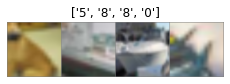

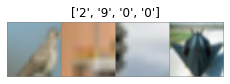

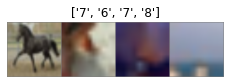

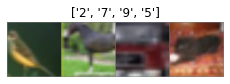

In [25]:
for i in range(batch_size):
    show_batch_images(trainloader)

## Creating VGG-16

In [26]:
from torchvision import models

In [27]:
vgg=models.vgg16_bn()

In [28]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [29]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [30]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [36]:
final_input_features=vgg.classifier[6].in_features
mod_classifier=list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_input_features,num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [37]:
vgg.classifier=nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Train CIFAR10 using VGG-16

In [39]:
batch_size=16
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=True)

In [43]:
def evaluation(dataloader,model):
    total,correct=0,0
    for data in dataloader:
        inputs,labels=data
        outputs=model(inputs)
        _,pred=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(pred==labels).sum().item()
    return 100*correct/total

In [44]:
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(vgg.parameters(),lr=0.05)

In [48]:
loss_epoch_arr=[]
epochs=1
n_iters=np.ceil(50000/batch_size)

for epoch in range(epochs):
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        
        opt.zero_grad()
        
        outputs=vgg(inputs)
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt.step()
        
        del inputs, labels, outputs
        
        if i%100==0:
            print("Iteration: %d %d, Loss: %0.2f" %(i,n_iters,loss.item()))
        
        loss_epoch_arr.append(loss.item())
        print("Epoch %d %d, Test acc: %0.2f, Train acc:%0.2f" %(epoch,epochs,evaluation(testloader,vgg),evaluation(trainloader,vgg)))

plt.plot(loss_epoch_arr)
plt.show()

Iteration: 0 3125, Loss: 21.21


KeyboardInterrupt: 

## Freeze layers of CNN

In [49]:
batch_size=16
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [50]:
vgg=models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\ANKUR SINGH/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth


In [51]:
for param in vgg.parameters():
    param.requires_grad=False

In [52]:
final_input_features=vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(final_input_features,num_classes)

In [54]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [55]:
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(vgg.parameters(),lr=0.05)

In [56]:
import copy

In [ ]:
loss_epoch_arr=[]
epochs=1
min_loss=1000
n_iters=np.ceil(50000/batch_size)

for epoch in range(epochs):
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        
        opt.zero_grad()
        
        outputs=vgg(inputs)
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt.step()
        
        if min_loss>loss.item():
            min_loss=loss.item()
            best_model=copy.deepcopy(vgg.state_dict())
            print("Min loss is %0.2f" %min_loss)
        
        if i%100==0:
            print("Iteration: %d %d, Loss: %0.2f" %(i,n_iters,loss.item()))
        
        loss_epoch_arr.append(loss.item())
        print("Epoch %d %d, Test acc: %0.2f, Train acc:%0.2f" %(epoch,epochs,evaluation(testloader,vgg),evaluation(trainloader,vgg)))

plt.plot(loss_epoch_arr)
plt.show()

Min loss is 2.26
Iteration: 0 3125, Loss: 2.26
